# Previsão de Preços de Carros Usados

Este projeto utiliza o dataset [Used Cars Price Prediction](https://www.kaggle.com/datasets/avikasliwal/used-cars-price-prediction), que contém informações detalhadas sobre veículos usados vendidos em diversas cidades da Índia. O conjunto de dados inclui variáveis como modelo, ano de fabricação, tipo de combustível, transmissão...

O objetivo deste notebook é realizar:
- Pré-processamento de variáveis categóricas e numéricas.
- Modelagem preditiva para estimar o preço de revenda dos veículos.
- Foco na aplicação do algoritmo Random Forest para regressão


## Dependências e Dataset

Baixando dataset do diretamente do Kaggle, extraindo e abrindo o conjunto de dados.

In [113]:
# Kaggle

!pip install -q kaggle

In [114]:
# Manipulação de Dados

import pandas as pd
import numpy as np
import zipfile

# Visualização

import matplotlib.pyplot as plt
import seaborn as sns

# Métricas
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# Scaler, RandomForest, SVM...
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split


# Google Colab para upload de arquivos locais
from google.colab import files


In [115]:
files.upload() # Kaggle JSON

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"patrickregis","key":"103d38076a1d4bb72439b211012992e0"}'}

In [116]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [117]:
!kaggle datasets download -d avikasliwal/used-cars-price-prediction

Dataset URL: https://www.kaggle.com/datasets/avikasliwal/used-cars-price-prediction
License(s): other
used-cars-price-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [118]:
with zipfile.ZipFile("used-cars-price-prediction.zip", "r") as zip_ref:
    zip_ref.extractall("dados")

In [135]:
# Carregando Dataset

df_train = pd.read_csv('dados/train-data.csv')
# df_test = pd.read_csv('dados/test-data.csv') -> Arquivo não tem target, dataset para competição. Usaremos somente o conjunto de treino

## Explorando o Dataset

In [136]:
# Valores Únicos

print(df_train.nunique())

Unnamed: 0           6019
Name                 1876
Location               11
Year                   22
Kilometers_Driven    3093
Fuel_Type               5
Transmission            2
Owner_Type              4
Mileage               442
Engine                146
Power                 372
Seats                   9
New_Price             540
Price                1373
dtype: int64


In [137]:
# Excluindo colunas desnecessárias

df_train.drop(['New_Price', 'Unnamed: 0', 'Name'], axis = 1, inplace = True)

In [138]:
# Removendo valores nulos

df_train.dropna(inplace=True,axis=0)

In [139]:
# Separando as features do target

y = df_train['Price']
X = df_train.drop('Price', axis=1)

# Tratando Formatações Problematicas

In [140]:
# As seguintes colunas estão em formato string. Milage tem duas possíveis métricas (kmpç e km/kg), necessário conversão.

columns = ['Mileage', 'Engine', 'Power']

for col in columns:
    print(f"Column: {col}")
    endings = set() # for uniques

    for i in X[col]:
        if isinstance(i, str):
            ending = i.split()[-1]
            endings.add(ending)

    print(f"Terminações encontradas: {endings}\n")

Column: Mileage
Terminações encontradas: {'kmpl', 'km/kg'}

Column: Engine
Terminações encontradas: {'CC'}

Column: Power
Terminações encontradas: {'bhp'}



In [141]:
# Convertendo km/kg para kmpl

New_Mileage= []

for i in X['Mileage']:
    if str(i).endswith('km/kg'):
        i = i[:-6]
        i = float(i)*1.40
        New_Mileage.append(float(i))
    elif str(i).endswith('kmpl'):
        i = i[:-6]
        New_Mileage.append(float(i))

In [142]:
X['Mileage']= New_Mileage

# Métricas finais: Mileage (kmpl), engine (CC), power (bhp)

In [143]:
# Formatar Engine e Power, remover texto.

X['Engine'] = X['Engine'].str.extract('(\d+\.\d+|\d+)').astype(float)
X['Power'] = X['Power'].str.extract('(\d+\.\d+|\d+)').astype(float)

In [144]:
# Renomear colunas com texto indicando a métrica usada.

rename = ['Mileage (kmpl)', 'Engine (CC)', 'Power (bhp)']
rename_dict = dict(zip(columns, rename))
X.rename(columns=rename_dict, inplace=True)

In [145]:
# Confirmando as alterações.

#X.head(3)

In [146]:
# Valores nulos para Power

print(X.isnull().sum())

Location               0
Year                   0
Kilometers_Driven      0
Fuel_Type              0
Transmission           0
Owner_Type             0
Mileage (kmpl)         0
Engine (CC)            0
Power (bhp)          103
Seats                  0
dtype: int64


In [147]:
# Imputando a média em valores nulos

imputer = SimpleImputer(strategy='mean')

# Imputar somente na coluna "Power"

X[['Power (bhp)']] = imputer.fit_transform(X[['Power (bhp)']])

In [148]:
# Dividir em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=31)

# Aplicando Dummies e Normalizando os Dados

In [149]:
# Dummies para variáveis categóricas

X_train = pd.get_dummies(X_train, drop_first=True)
X_val = pd.get_dummies(X_val, drop_first=True)

In [154]:
# Normalizando os Dados

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Random Forest Regressor

In [158]:
# 1. Treinamento com treino escalonado
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train_scaled, y_train)

# 2. Previsões
y_train_pred = rf_reg.predict(X_train_scaled)
y_test_pred = rf_reg.predict(X_val_scaled)

# 3. Avaliação com R²
print("R² no treino:", rf_reg.score(X_train_scaled, y_train))
print("R² no teste:", rf_reg.score(X_val_scaled, y_val))

R² no treino: 0.983127487790837
R² no teste: 0.9059782718105918


MSE: 11.39
RMSE: 3.37
R²: 0.91
Correlação (Pearson): 0.95


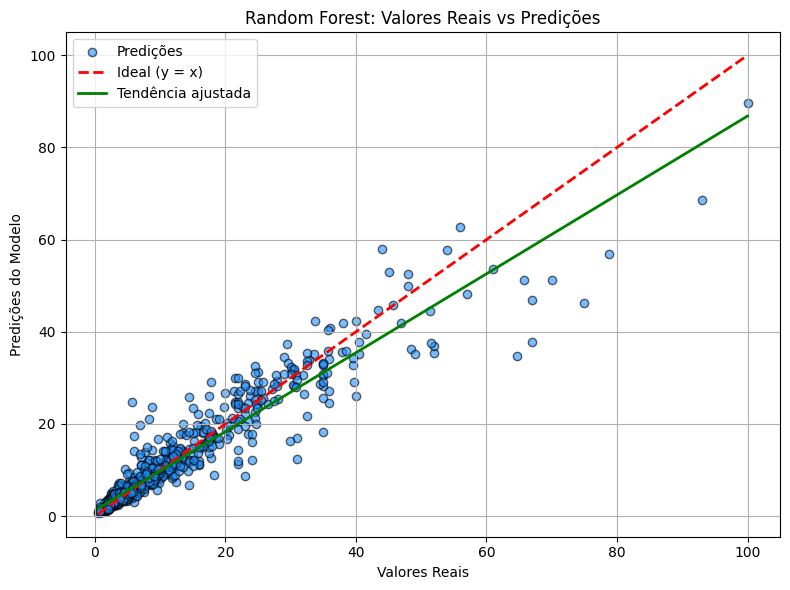

In [164]:
import matplotlib.pyplot as plt

import numpy as np

# Gerar predições no conjunto de validação
y_pred = rf_reg.predict(X_val_scaled)

# Métricas
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)
corr, _ = pearsonr(y_val, y_pred)  # Correlação de Pearson

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")
print(f"Correlação (Pearson): {corr:.2f}")

# Visualização: valores reais x predições
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred, alpha=0.6, color='dodgerblue', edgecolor='k', label='Predições')

# Linha y=x
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, label='Ideal (y = x)')

# Linha de tendência linear ajustada
z = np.polyfit(y_val, y_pred, 1)
p = np.poly1d(z)
plt.plot(sorted(y_val), p(sorted(y_val)), "g-", lw=2, label='Tendência ajustada')

plt.xlabel('Valores Reais')
plt.ylabel('Predições do Modelo')
plt.title('Random Forest: Valores Reais vs Predições')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()